# PG Diploma in Machine Learning and AI March 2018
## EDA Case Study
In this notebook we analyse the potential drivers for loan default. We attempt to discover insights through Exploratory Data Analysis (EDA) that will help business identify customers who are at high risk to default.

- **Bishwarup Bhattacharjee** (write2bishwarup@gmail.com)
- **Sabyasachi Dey** (sabyasachidey1@outlook.com)
- **Akansha Jawanpuria** (akansha.jawanpuria@gmail.com)
- **Ravi Kumar N K** (ravink259@gmail.com)


In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import Counter, OrderedDict

%matplotlib inline
color = sns.color_palette()
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

## 1. Load and Clean the dataset

In [2]:
loans = pd.read_csv("./loan.csv")
print("Toal numnber of applicants in the data: {}".format(loans.shape[0]))

Toal numnber of applicants in the data: 39717


In [3]:
cnt = loans.loan_status.value_counts()
print("Total number of paid-off loans: {}".format(cnt["Fully Paid"]))
print("Total number of current loans: {}".format(cnt["Current"]))
print("Total number of Defaults: {}".format(cnt["Charged Off"]))
print("\nOverall default rate: {}%".format("%.2f" %(100* cnt["Charged Off"] / loans.shape[0])))

Total number of paid-off loans: 32950
Total number of current loans: 1140
Total number of Defaults: 5627

Overall default rate: 14.17%


In [270]:
loans.funded_amnt.sum()

434810325

#### Clean NA and constant columns

Let's find out if we have any columns with all null values. We shall also remove the constant columns as those are not helpful for our analysis.

In [4]:
null_columns = loans.columns[loans.apply(lambda x: pd.isnull(x).sum() == len(x))]
constant_columns = loans.columns[loans.apply(lambda x: x.nunique() == 1)]
print("Total number of null variables in the data: {}".format(len(null_columns)))
print("Total number of null variables in the data: {}".format(len(constant_columns)))
print("\nThe null columns are: \n{}\n".format(", ".join(null_columns.tolist())))
print("The constant columns are: \n: {}".format(", ".join(constant_columns.tolist())))

Total number of null variables in the data: 54
Total number of null variables in the data: 9

The null columns are: 
mths_since_last_major_derog, annual_inc_joint, dti_joint, verification_status_joint, tot_coll_amt, tot_cur_bal, open_acc_6m, open_il_6m, open_il_12m, open_il_24m, mths_since_rcnt_il, total_bal_il, il_util, open_rv_12m, open_rv_24m, max_bal_bc, all_util, total_rev_hi_lim, inq_fi, total_cu_tl, inq_last_12m, acc_open_past_24mths, avg_cur_bal, bc_open_to_buy, bc_util, mo_sin_old_il_acct, mo_sin_old_rev_tl_op, mo_sin_rcnt_rev_tl_op, mo_sin_rcnt_tl, mort_acc, mths_since_recent_bc, mths_since_recent_bc_dlq, mths_since_recent_inq, mths_since_recent_revol_delinq, num_accts_ever_120_pd, num_actv_bc_tl, num_actv_rev_tl, num_bc_sats, num_bc_tl, num_il_tl, num_op_rev_tl, num_rev_accts, num_rev_tl_bal_gt_0, num_sats, num_tl_120dpd_2m, num_tl_30dpd, num_tl_90g_dpd_24m, num_tl_op_past_12m, pct_tl_nvr_dlq, percent_bc_gt_75, tot_hi_cred_lim, total_bal_ex_mort, total_bc_limit, total_il_hig

We shall **remove all 63 columns** from our dataset as they bear no information about the business problem we are dealing with.

In [5]:
loans.drop(null_columns.tolist() + constant_columns.tolist(), axis = 1, inplace=True)

Actually we shall also **remove columns that contain more than 50% missing values**. Let's find out what are the columns with high NA counts.

In [6]:
na_counts = pd.isnull(loans).sum()
high_na_cols = na_counts[na_counts >= np.int32(loans.shape[0]/2)]
print(high_na_cols)

mths_since_last_delinq    25682
mths_since_last_record    36931
next_pymnt_d              38577
dtype: int64


Turns out 
    - mths_since_last_delinq
    - mths_since_last_record
    - next_pymnt_d
have high count of nulls. So we shall exclude these variables too from our analysis

In [7]:
loans.drop(high_na_cols.index.tolist(), axis = 1, inplace = True)

Let's print the first few rows of the data to get a feel how our dataset looks like.

In [8]:
print("dimension of our dataset after removing the columns: {}".format(loans.shape))
loans.head()

dimension of our dataset after removing the columns: (39717, 45)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,pub_rec_bankruptcies
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,5833.84,5000.00,863.16,0.00,0.00,0.00,Jan-15,171.62,May-16,0.0
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,Sep-13,0.0
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,3005.67,2400.00,605.67,0.00,0.00,0.00,Jun-14,649.91,May-16,0.0
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,12231.89,10000.00,2214.92,16.97,0.00,0.00,Jan-15,357.48,Apr-16,0.0
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,3513.33,2475.94,1037.39,0.00,0.00,0.00,May-16,67.79,May-16,0.0


In [9]:
# remove the 'months' suffix. We could split on blank space but in case for some observations
# there is no blanks space the code will raise exception. Hence we handle that through re search
# method and extract the number from the text
loans["term"] = loans["term"].map(lambda x: re.search(r"\d+", x).group(0))

# remove '%' suffix from int_rate and revol_util to cast the columns as float
loans["int_rate"] = loans["int_rate"].map(lambda x: np.float32(re.sub("%", "", str(x))))
loans["revol_util"] = loans["revol_util"].map(lambda x: np.float32(re.sub("%", "", str(x))))

# format emp-length - we shall make 
#< 1 year = 0 and 
# 10+ years = 10 
#for the sake of analysis
loans["emp_length"][loans["emp_length"] == '< 1 year'] = '0 years'
loans["emp_length"] = loans["emp_length"].map(lambda x: np.nan if pd.isnull(x) else 
                                              np.float32(re.sub(r"\+|\s+|year(s)?|<", "", x)))

#### Impute missing values

Let's see what columns have missing values and find out what would be an ideal way of imputing those missing values.

In [10]:
mis_val_counts = pd.isnull(loans).sum()
mis_val_names = mis_val_counts[mis_val_counts > 0]
print(mis_val_names)

emp_title                2459
emp_length               1075
desc                    12940
title                      11
revol_util                 50
last_pymnt_d               71
last_credit_pull_d          2
pub_rec_bankruptcies      697
dtype: int64


Let's impute the numeric columns with median and categoricals with mode. However, for the date columns i.e. last_payment_d and last_credit_pull_d we shall do nothing for now. We shall also treat the variable 'desc' later.

In [11]:
impute_cols = [col for col in mis_val_names.index.tolist() if col not in 
               ["last_pymnt_d", "last_credit_pull_d", "desc"]]
for col in impute_cols:
    if loans[col].dtype == 'object':
        loans[col][pd.isnull(loans[col])] = loans[col].mode()[0]
    elif loans[col].dtype == 'int' or loans[col].dtype == 'float':
        loans[col][pd.isnull(loans[col])] = loans[col].median()
    else:
        pass

Now, let us look at the missing value patterns of the column 'last_pymnt_d'.

In [12]:
loans[pd.isnull(loans.last_pymnt_d)].loan_status.value_counts()

Charged Off    71
Name: loan_status, dtype: int64

So, **all the null values of 'last_pymnt_d' correspond to the Charged Off or defaulted status**. This is quite intuitive as these applicants might have never paid any installments at all. We shall interpret the nulls that way and leave the column as it is as it doesn't make sense to impute the missing values here.

For the other date column i.e. 'last_credit_pull_d' - we have only a couple of missing values. We shall take the issuing date as the last credit pull date for these two cases.

In [13]:
loans["last_credit_pull_d"][pd.isnull(loans["last_credit_pull_d"])] = loans["issue_d"]

Just a sanity check before we move on. Let's find out if we missed any column for imputation.

In [14]:
mis_val_counts = pd.isnull(loans).sum()
mis_val_names = mis_val_counts[mis_val_counts > 0]
print(mis_val_names)

desc            12940
last_pymnt_d       71
dtype: int64


Done! We have imputed all the columns containing missing values apart from 'last_pymnt_d' and 'desc' which we left untouched intentionally at this point.

#### Type driven variables
Next we shall clean the data further which includes formatting date variables, changing types of interest rate, term etc. Corresponding to each date column we shall create two new columns - one for the month and the other for the year. Let's start with the date columns first.

In [15]:
# We left the missing values in the column last_pymnt_d as is. However, here we
# need to impute that in order to process the column farther. We shall impute it 
# with a very irregular value e.g. Jan-20 i.e. Jan, 1920 so that we know that's a
# proxy for the missing value in that column. Jan, 1920 is just a placeholder.
loans["last_pymnt_d"][pd.isnull(loans["last_pymnt_d"])] = "Jan-20"

# we shall use this dict to map the integer values to the string month names
month_dict = {   "Jan" : 1,
                 "Feb" : 2,
                 "Mar" : 3,
                 "Apr" : 4,
                 "May" : 5,
                 "Jun" : 6,
                 "Jul" : 7,
                 "Aug" : 8,
                 "Sep" : 9,
                 "Oct" : 10,
                 "Nov" : 11,
                 "Dec" : 12,
             }

# since the date has two digit years we need to interpret whether it is in 1k9 or 2k
def process_years(x):
    x = np.int32(x)
    if x >= 19:
        year = 1900 + np.uint8(x)
    else:
        year = 2000 + np.uint8(x)
    return year

date_cols = [col for col in loans.columns if re.match(r".*_d$", col)] + ["earliest_cr_line"]
for col in date_cols:
    month_col_name, year_col_name = col + "_month", col + "_year"
    loans[month_col_name] = loans[col].map(lambda x: month_dict.get(x.split("-")[0]))
    loans[year_col_name] = loans[col].map(lambda x: process_years(x.split("-")[1]))

# let's print a processed date column and two derived columns to check if we are doing it right
print(loans[["issue_d", "issue_d_month", "issue_d_year"]].head())

  issue_d  issue_d_month  issue_d_year
0  Dec-11             12          2011
1  Dec-11             12          2011
2  Dec-11             12          2011
3  Dec-11             12          2011
4  Dec-11             12          2011


That looks pretty much what we had expected.

#### Data driven variables

Next, we shall process a few other columns to make them amenable for further processing.

Let's print a few rows of the formatted columns.

In [16]:
loans[["term", "int_rate", "revol_util", "emp_length"]].head()

,term,int_rate,revol_util,emp_length
0,36,10.65,83.699997,10.0
1,60,15.27,9.400000,0.0
2,36,15.96,98.500000,10.0
3,36,13.49,21.000000,10.0
4,60,12.69,53.900002,1.0


Looks good. Next, we shall derive a few more variables from the business point of view.

#### Business driven variables

In [17]:
# difference between loan amount and funded amount. We want to assess if the LC 
# assessed the applicant's credit eligibility as less than the loan amount asked for
loans["diff_loanAmt_fundAmt"] = loans["loan_amnt"] - loans["funded_amnt"]

# ratio of the loan amount funded to self-reported annual income
loans["rat_fundAmt_annualInc"] = loans["funded_amnt"] / loans["annual_inc"]

# age of credit line
loans["age_credit_line_yrs"] = loans["issue_d_year"] - loans["earliest_cr_line_year"]

# ratio to loan amt to balance in revolving credit lines - 
loans["rat_loanAmt_revolBal"] = (loans["loan_amnt"] + loans["revol_bal"]) / loans["annual_inc"]

# is any public derogatory reports available
loans["is_pub_rec"] = loans["pub_rec"].map(lambda x: 1 if x > 0 else 0)

# is any bankrupcies reported in past
loans["is_pub_bankrupt"] = loans["pub_rec_bankruptcies"].map(lambda x: 1 if x> 0 else 0)

# if the applicant has provided a description while applying
loans["is_desc"] = loans["desc"].map(lambda x: 0 if pd.isnull(x) else 1)

# if delinquent at least once in last 2 years
loans["is_delinq_2_yrs"] = loans["delinq_2yrs"].map(lambda x: 0 if x == 0 else 1)

#### Process text columns

In [18]:
# clean the description field and create a few other variables
def process_desc(x):
    if pd.isnull(x):
        return np.nan
    patterns = re.compile(r"<br/?>|Borrower added on (\d+)/(\d+)/(\d+)|\>")
    x = re.sub(patterns, "", x).strip()
    return x

loans["desc"] = loans["desc"].map(lambda x: process_desc(x))
loans["words_in_desc"] = loans["desc"].map(lambda x: len(str(x).split(" ")))
loans["chars_in_desc"] = loans["desc"].map(lambda x: len(str(x)))

loans["words_in_title"] = loans["title"].map(lambda x: len(str(x).split(" ")))
loans["chars_in_title"] = loans["title"].map(lambda x: len(str(x)))

#### Outlier treatment

Let's look at a few columns where we suspect that there might be potential outliers. Let's start with annual income of the applicants.

In [19]:
loans.annual_inc.describe()

count    3.971700e+04
mean     6.896893e+04
std      6.379377e+04
min      4.000000e+03
25%      4.040400e+04
50%      5.900000e+04
75%      8.230000e+04
max      6.000000e+06
Name: annual_inc, dtype: float64

[]

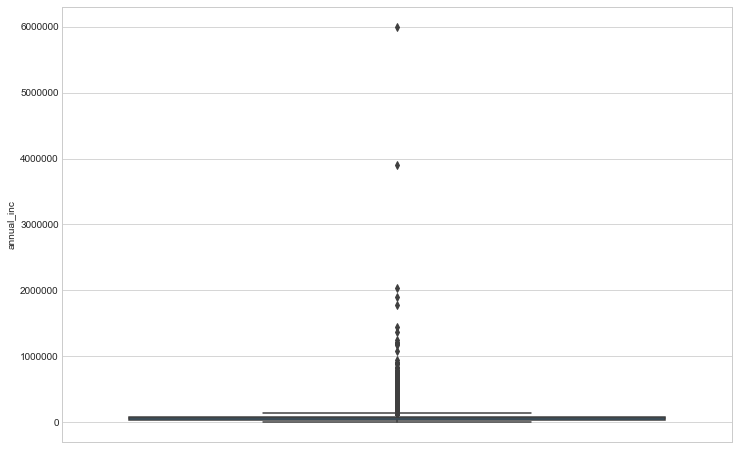

In [20]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=loans, y="annual_inc")
plt.plot()

While the 75th percentile or third quartile of the income distribution is at $82,300, the maximum income in the dataset is reported to be USD 6M. The long whisker in the boxplot pointing upwards also tells the fact that there are a lot of exorbitant incomes reported in the dataset. One way to know if these are outliers is to assess if the income has been verified by the bank. In case it's not we can more-or-less safely declare the eccentric incomes as being outliers.

Let's see how many incomes above the 3rd quartile have been verified by the LC.

In [21]:
loans[loans.annual_inc > np.percentile(loans.annual_inc, 75)]["verification_status"].value_counts()

Verified           4621
Not Verified       2997
Source Verified    2311
Name: verification_status, dtype: int64

There are ~ 3,000 applicants reported high incomes but their incomes have not been verified by the LC.

## 2) Univariate Analysis

In this part of our analysis, we shall look into different variables that are included in the cleaned dataset and what their distributions look like. 

Let's start with **loan status** - which is the variable of our interest and find out its distribution in the dataset.

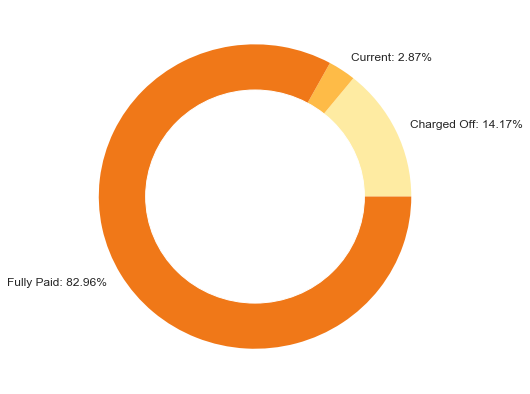

In [22]:
ls_smry = loans.groupby('loan_status').agg('size').reset_index()
ls_smry.columns = ["loan_status", "cnt"]
ls_smry["pct"] = 100 * ls_smry["cnt"] / loans.shape[0]

names=ls_smry.loan_status.tolist()
size=ls_smry["cnt"].tolist()
pct = [str(np.round(x, 2)) for x in ls_smry["pct"].tolist()]

lbl = [x[0] + ": " + x[1] + '%' for x in zip(names, pct)]

plt.figure(figsize=(7, 7))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=lbl, colors=sns.color_palette("YlOrBr", 4), textprops = {'fontsize' : 12})
p=plt.gcf()
p.gca().add_artist(my_circle)
#plt.savefig("./plot1.png", bbox_inches='tight', transparent = True)
plt.show()

Almost 83% of the loans have been fully paid-off by the consumer. There are only ~ 14% loans that have been charged off and the rest 3% have ongoing installments.

**Loan grade** is also a very important variable. Loan grade is an ordinal score that is assigned to each loan issued by the LC reflecting the quality and risk of the loan. The grade A corresponds to the loans that are most secure and have high probability of getting paid-off. B represent a little less secure than A, C is a more risky than B and so on. Let's look at the number of loans in this categories.

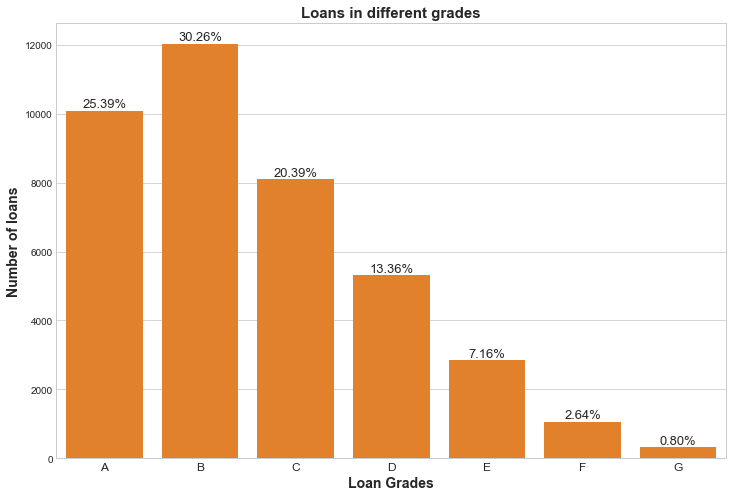

In [23]:
plt.figure(figsize=(12, 8))
ax = sns.countplot(data=loans, x="grade", order=["A", "B", "C", "D", "E", "F", "G"], color = color[1])
plt.title('Loans in different grades', fontsize =15, fontweight= "bold")
plt.xlabel("Loan Grades", fontsize= 14, fontweight = "bold")
plt.ylabel("Number of loans", fontsize= 14, fontweight = "bold")
plt.xticks(fontsize = 12)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 100,
            str('{:1.2f}'.format(height*100/loans.shape[0]))+'%',
            ha="center",
           fontdict = {"fontsize" : 13}) 
plt.show()

**More than 50% loans belong to grade A and B** while grades of E, F and G together contains around 10% of total loans issues by the LC. 

[]

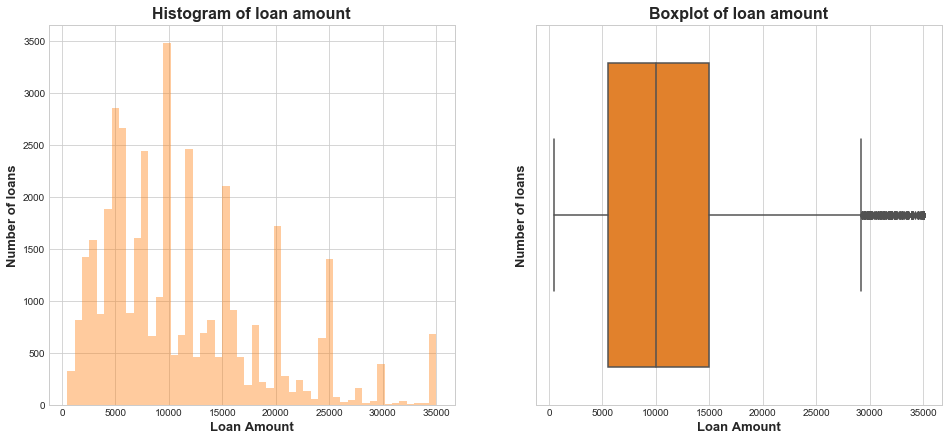

In [24]:
plt.figure(figsize=(16, 7))

plt.subplot(1, 2, 1)
sns.distplot(loans.loan_amnt, color = color[1], kde = False)
plt.title("Histogram of loan amount", fontsize = 16, fontweight='bold')
plt.xlabel("Loan Amount", fontsize = 13, fontweight = 'bold')
plt.ylabel("Number of loans", fontsize = 13, fontweight = 'bold')

plt.subplot(1, 2, 2)
sns.boxplot(loans.loan_amnt, color = color[1])
plt.title("Boxplot of loan amount", fontsize = 16, fontweight='bold')
plt.xlabel("Loan Amount", fontsize = 13, fontweight = 'bold')
plt.ylabel("Number of loans", fontsize = 13, fontweight = 'bold')
plt.plot()

As we can see from the above plots, the distribution for asked loan amounts is a **positively skewed** distribution with majority of loans between `$`5,000 to `$`15,000. There also seems to be a spike in multiples of `$`5,000. We also figure out all the loan amounts greater than `$`35,000 have been clubbed at `$`35k resulting in the fairly big spike there. We can safely assume, the LC at this point only approve loans up to `$`35K.

Let's also take a glance at tenures and interest rate.

[]

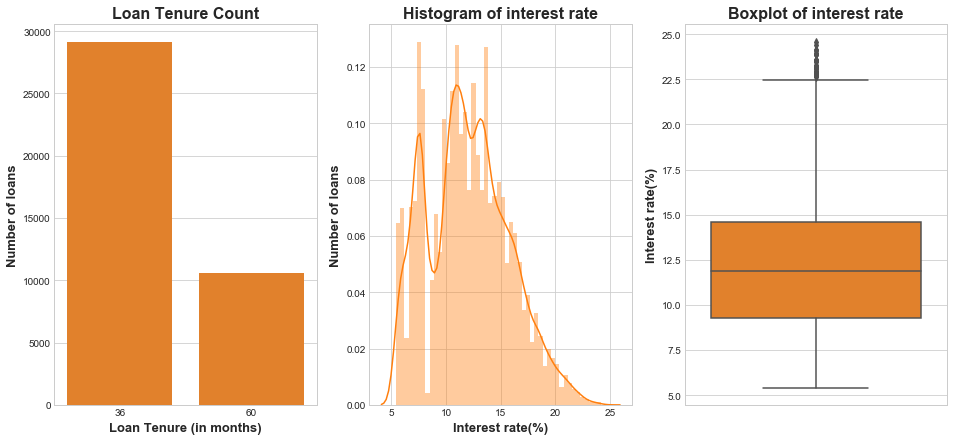

In [25]:
plt.figure(figsize=(16, 7))
plt.subplot(1, 3, 1)
sns.countplot(loans.term, color = color[1])
plt.title("Loan Tenure Count", fontsize = 16, fontweight='bold')
plt.xlabel("Loan Tenure (in months)", fontsize = 13, fontweight = 'bold')
plt.ylabel("Number of loans", fontsize = 13, fontweight = 'bold')

plt.subplot(1, 3, 2)
sns.distplot(loans.int_rate, color = color[1])
plt.title("Histogram of interest rate", fontsize = 16, fontweight='bold')
plt.xlabel("Interest rate(%)", fontsize = 13, fontweight = 'bold')
plt.ylabel("Number of loans", fontsize = 13, fontweight = 'bold')
plt.plot()

plt.subplot(1, 3, 3)
sns.boxplot(data=loans, y = 'int_rate', color =color[1])
plt.title("Boxplot of interest rate", fontsize = 16, fontweight='bold')
#plt.xlabel("Interest rate", fontsize = 13, fontweight = 'bold')
plt.ylabel("Interest rate(%)", fontsize = 13, fontweight = 'bold')
plt.plot()


It is evident that the LC only sanctions loans for a period over 3 and 5 years while 3 years being most common. On the interest rate side - it looks quite like a multimodal distribution with most of the loans carrying interest rate somewhere between 8% to 14%. The interest rate for some people are also very high reaching upto an extreme of close to 25%.

Let us also take a look the number of loan applications from different states.

[]

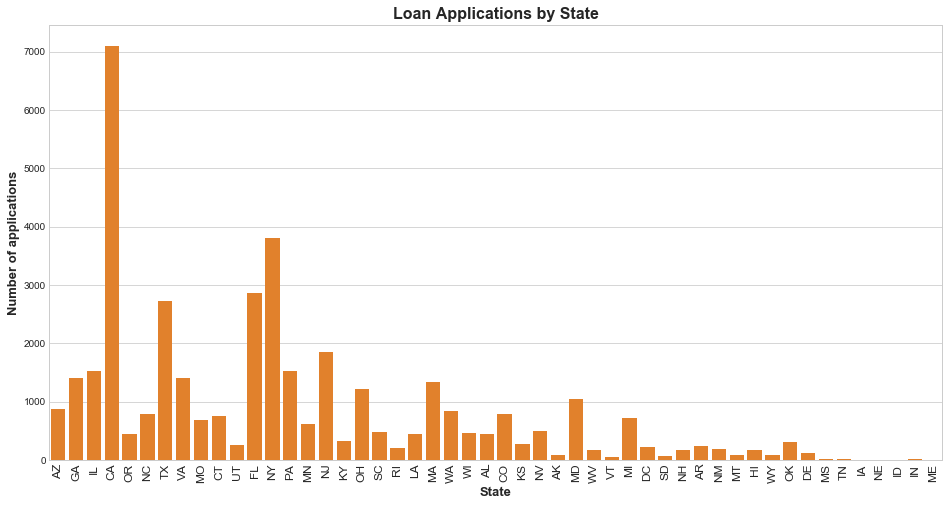

In [26]:
plt.figure(figsize=(16, 8))
sns.countplot(data=loans, x = "addr_state", color=color[1])
plt.title("Loan Applications by State", fontsize = 16, fontweight='bold')
plt.xlabel("State", fontsize = 13, fontweight = 'bold')
plt.ylabel("Number of applications", fontsize = 13, fontweight = 'bold')
plt.xticks(rotation = "vertical", fontsize =12)
plt.plot()

Majority of the loan applications come from California (CA), New York (NY), Floirda(FL) and Texus(TX). Many of the states like Mississippi (MS), Indiana (IN), Iowa (IA) etc. have very low number of applications coming from there. To make our analysis more robust, we shall club all these states into a single category named 'Others'

In [27]:
# we shall merge all state having 100 or less applications into 'Others'
st_appl_cnt = loans.addr_state.value_counts()
low_appl_states = st_appl_cnt[st_appl_cnt <= 100].index.tolist()
loans["addr_state"] = loans["addr_state"].map(lambda x: "Others" if x in low_appl_states else x)
print("Number of states in the dataset after clubbing: {}".format(loans.addr_state.nunique()))

Number of states in the dataset after clubbing: 39


Lastly let us also find out what purpose do the applicants apply the loan for with the LC.

[]

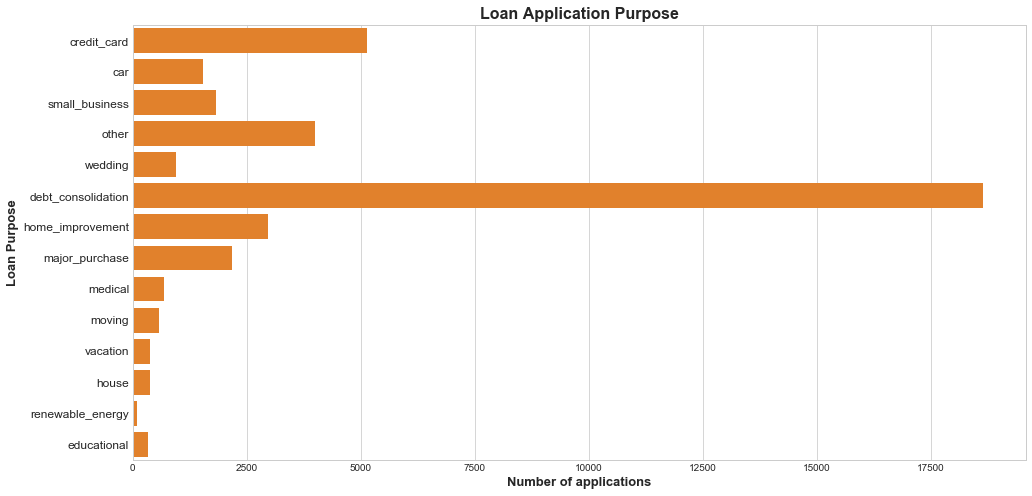

In [28]:
plt.figure(figsize=(16, 8))
sns.countplot(data=loans, y = "purpose", color=color[1])
plt.title("Loan Application Purpose", fontsize = 16, fontweight='bold')
plt.xlabel("Number of applications", fontsize = 13, fontweight = 'bold')
plt.ylabel("Loan Purpose", fontsize = 13, fontweight = 'bold')
plt.yticks(fontsize =12)
plt.plot()

That's interesting. Vast majority of the applicants apply for the loan to consolidate their other ongoing debts. This has to do with the realization that if the debt is left inconsolidated for a period of time the applicant has to pay regular interest on that. In order to avoid that, many opts for a personal loan to close all the debt accounts once and for all. 

Actually let us dig a little deeper and find out what are these debts people are applying loans for.

In [29]:
title = loans[loans.purpose == 'debt_consolidation'].title.tolist() # get all title corresponding to purpose debt consolidation
title = " ".join([str(x) for x in title]) # make a big string of all such titles
title = title.split(" ") # split the big string to get the individual words in it
title = [x.lower().strip() for x in title] # lowercase and strip to club similar words written differently
c = Counter(title) # create a frequency distributions of those words
print(c.most_common(20)) # print the top 20 most frequent words across all the titles

[('debt', 8132), ('consolidation', 7633), ('loan', 4892), ('credit', 2083), ('card', 1350), ('pay', 804), ('off', 765), ('consolidate', 748), ('personal', 746), ('payoff', 587), ('cards', 579), ('', 571), ('my', 556), ('to', 519), ('of', 464), ('and', 320), ('interest', 279), ('out', 275), ('get', 273), ('free', 271)]


We see all kinds of interesting words their - for example **credit**, **cards**, **interests**, **pay**, **off** etc. So for most of the people it's the outstanding balance that they want to pay off to guard against the APR the cards charge.

Now with the knowledge that we have gathered so far, let's do some segmented analysis to explore the dataset in further granularity.

## 3) Segmented Univariate Analysis

In this section of our analysis, we shall try to aseess how a variable of interest is distributed over another variable. To frame it in a more technical manner, we shall investigate a number of different conditional distributions of the variables included in the dataset. Since, our major goal of this EDA is to find potential drivers of loan default, we shall take the variable loan status as the variable of our interest and explore its conditional distribution over other important variables.

As one would presume, the loan grade is likely to have substantial impact on the probability of an applicant defaulting. We shall compare the rate of default across each of these loan grades.

[]

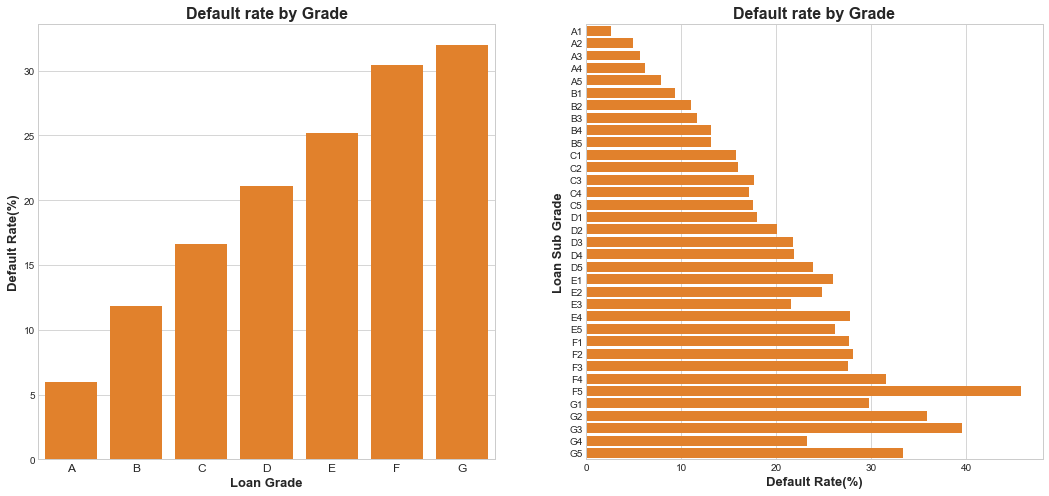

In [30]:
grade_rod = loans.groupby(["grade", "loan_status"])["member_id"].agg("size").reset_index()
grade_rod["n_appl"] = grade_rod.groupby("grade")["member_id"].transform("sum")
grade_rod["prop"] = 100 * (grade_rod["member_id"] / grade_rod["n_appl"])

subgrade_rod = loans.groupby(["sub_grade", "loan_status"])["member_id"].agg("size").reset_index()
subgrade_rod["n_appl"] = subgrade_rod.groupby("sub_grade")["member_id"].transform("sum")
subgrade_rod["prop"] = 100 * (subgrade_rod["member_id"] / subgrade_rod["n_appl"])

plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
sns.barplot(data=grade_rod[grade_rod.loan_status == "Charged Off"], x="grade", y = "prop", color=color[1])
plt.title("Default rate by Grade", fontsize = 16, fontweight='bold')
plt.xlabel("Loan Grade", fontsize = 13, fontweight = 'bold')
plt.ylabel("Default Rate(%)", fontsize = 13, fontweight = 'bold')
plt.xticks(fontsize =12)
plt.plot()


plt.subplot(1, 2, 2)
sns.barplot(data=subgrade_rod[subgrade_rod.loan_status == "Charged Off"], x="prop", y = "sub_grade", color =color[1])
plt.title("Default rate by Grade", fontsize = 16, fontweight='bold')
plt.xlabel("Default Rate(%)", fontsize = 13, fontweight = 'bold')
plt.ylabel("Loan Sub Grade", fontsize = 13, fontweight = 'bold')
#plt.xticks(fontsize =12)
plt.plot()


This is in line with what we had expected. A, being the most secure type of loan has a default rate of just over 5% where G, has a default rate of over 30%. The rate of default keeps growing steadily from A through G. For the subgrades, although the trend is similar to that of grades, but the growth of default rate over the subgrades are not that steady in that there are intermittent spikes. An interesting finding that's worth highlighting here is the **subgrade F5 has been most vulnerable to default - having a default rate well over 45%**.

We also assume interest rate to have a high impact on default rate. Loans with a higher interest rate is likely to have more defaults than that with lower interest rates. Also, is it safe to assume that higher tenure with a high interest rate would lead to even higher defaults? Let's find out.

[]

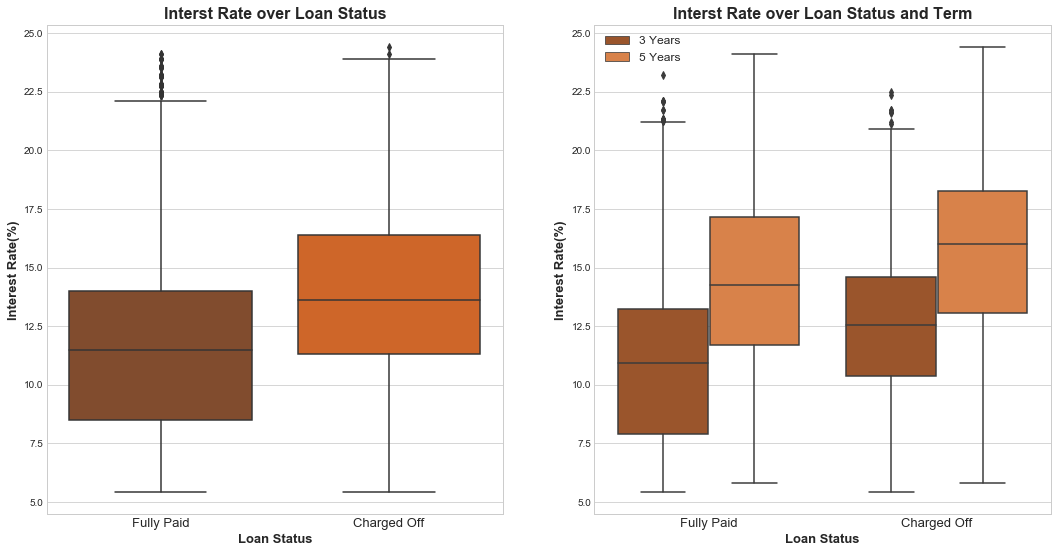

In [31]:
plt.figure(figsize=(18, 9))

plt.subplot(1, 2, 1)
sns.boxplot(data=loans[(loans.loan_status == "Charged Off") | (loans.loan_status == "Fully Paid")], 
            x="loan_status", y = "int_rate", palette=sns.color_palette("Oranges_d", 3))
plt.title("Interst Rate over Loan Status", fontsize = 16, fontweight='bold')
plt.xlabel("Loan Status", fontsize = 13, fontweight = 'bold')
plt.ylabel("Interest Rate(%)", fontsize = 13, fontweight = 'bold')
plt.xticks(fontsize =13)

plt.subplot(1, 2, 2)
sns.boxplot(data=loans[(loans.loan_status == "Charged Off") | (loans.loan_status == "Fully Paid")], 
            x="loan_status", y = "int_rate", hue = "term",palette=sns.color_palette("Oranges_d", 2))
plt.title("Interst Rate over Loan Status and Term", fontsize = 16, fontweight='bold')
plt.xlabel("Loan Status", fontsize = 13, fontweight = 'bold')
plt.ylabel("Interest Rate(%)", fontsize = 13, fontweight = 'bold')
plt.xticks(fontsize =13)
L=plt.legend(fontsize = 12)
L.get_texts()[0].set_text('3 Years')
L.get_texts()[1].set_text('5 Years')

plt.plot()

As we can clearly see from the boxplot, the 1st, 2nd (median) and 3rd quartile of intereset rate for charged off cases are clearly much higher than that of the fully paid cases. That being said, the range of interest rates for both the cases are almost similar, which means there are also people who defaults even with a low interest rate. 

The grouped boxplot on the right hand side also conveys an interesting story. The major takeaway from that graph is that loans with a repayment tenure of 5 years yield much higher interest rates than that compared to 3 years. 

So that's one way of looking at it. We may also want to know how the movement of default rates over different interest rate slabs. Let's find it out.

In [32]:
loans["int_rate_slab"] = ""
loans["int_rate_slab"][loans["int_rate"] <= 5] = "0% - 5%"
loans["int_rate_slab"][(loans["int_rate"] > 5) & (loans["int_rate"] <= 10)] = "5% - 10%"
loans["int_rate_slab"][(loans["int_rate"] > 10) & (loans["int_rate"] <= 15)] = "10% - 15%"
loans["int_rate_slab"][(loans["int_rate"] > 15) & (loans["int_rate"] <= 20)] = "15% - 20%"
loans["int_rate_slab"][(loans["int_rate"] > 20) & (loans["int_rate"] <= 25)] = "20% - 25%"

intrate_rod = loans.groupby(["loan_status", "int_rate_slab"])["member_id"].agg("size").reset_index()


In [33]:
intrate_rod["n_appl"] = intrate_rod.groupby("int_rate_slab")["member_id"].transform("sum")
intrate_rod["rod"] = 100 * (intrate_rod["member_id"] / intrate_rod["n_appl"])

[]

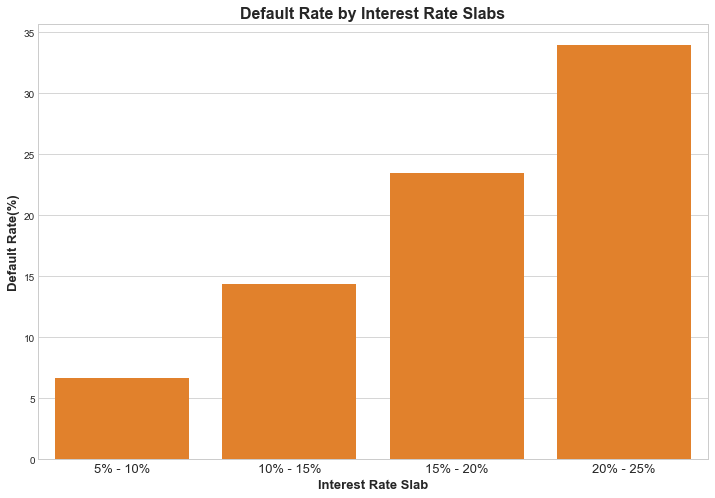

In [34]:
plt.figure(figsize=(12, 8))
sns.barplot(data=intrate_rod[intrate_rod.loan_status == "Charged Off"], 
            x="int_rate_slab", y="rod", color = color[1],
           order=["5% - 10%", "10% - 15%", "15% - 20%", "20% - 25%"])
plt.title("Default Rate by Interest Rate Slabs", fontsize = 16, fontweight='bold')
plt.xlabel("Interest Rate Slab", fontsize = 13, fontweight = 'bold')
plt.ylabel("Default Rate(%)", fontsize = 13, fontweight = 'bold')
plt.xticks(fontsize =13)
plt.plot()

So higher interest rate steadily increases the risk of default as seen above. 

Now with two potential indicators of default i.e. loan grade and interest rate, we want to know if these two indicators are inter-related which is quite likey as the grade carrying more risk will probably lead to higher interest rate towards the applicant. Is there a perfect causality relationship between these two indicators. Let's make another plot to check that.

[]

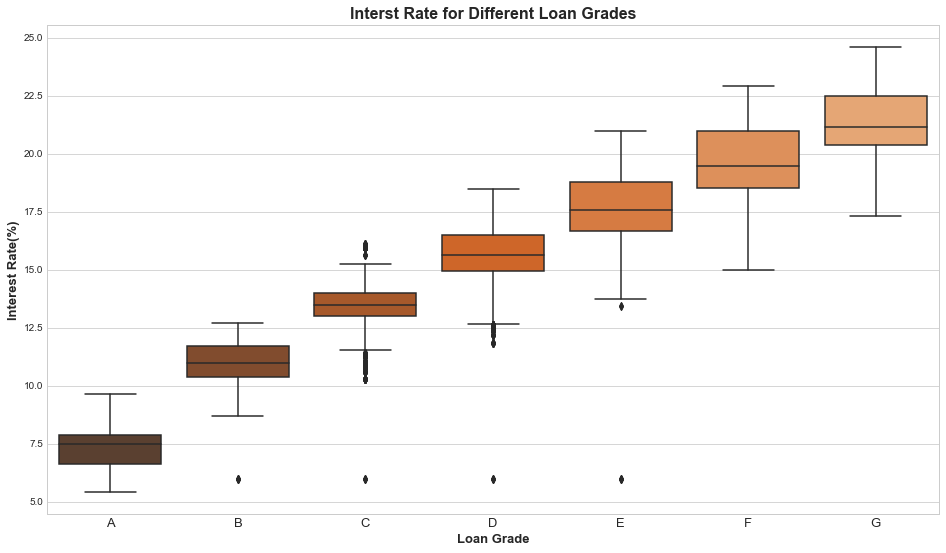

In [35]:
plt.figure(figsize=(16, 9))

sns.boxplot(data=loans, 
            x="grade", y = "int_rate", palette=sns.color_palette("Oranges_d", 7),
           order=list("ABCDEFG"))
plt.title("Interst Rate for Different Loan Grades", fontsize = 16, fontweight='bold')
plt.xlabel("Loan Grade", fontsize = 13, fontweight = 'bold')
plt.ylabel("Interest Rate(%)", fontsize = 13, fontweight = 'bold')
plt.xticks(fontsize =13)
plt.plot()

Looks like there is a monotonic relationship. Less secure loan grade almost always implies a higher interest rate leading to higher defaults.

The loan amount is also likey to impact the probability of default in that small loans are much easier to repay than the bigger ones where one has to pay a much higher interest amount throughout the tenure of the loan.

In [36]:
#loans["loan_amt_slab"] = np.digitize(loans.funded_amnt, np.arange(500, 35000, 2000))
loans["loan_amt_slab"] = pd.cut(loans.funded_amnt, np.arange(500, 37499, 2000))

In [37]:
grp = loans.groupby(["loan_status", "loan_amt_slab"])["member_id"].agg("size").reset_index()
grp["n_appl"] = grp.groupby("loan_amt_slab")["member_id"].transform("sum")
grp["rod"] = 100 * (grp["member_id"] / grp["n_appl"])

[]

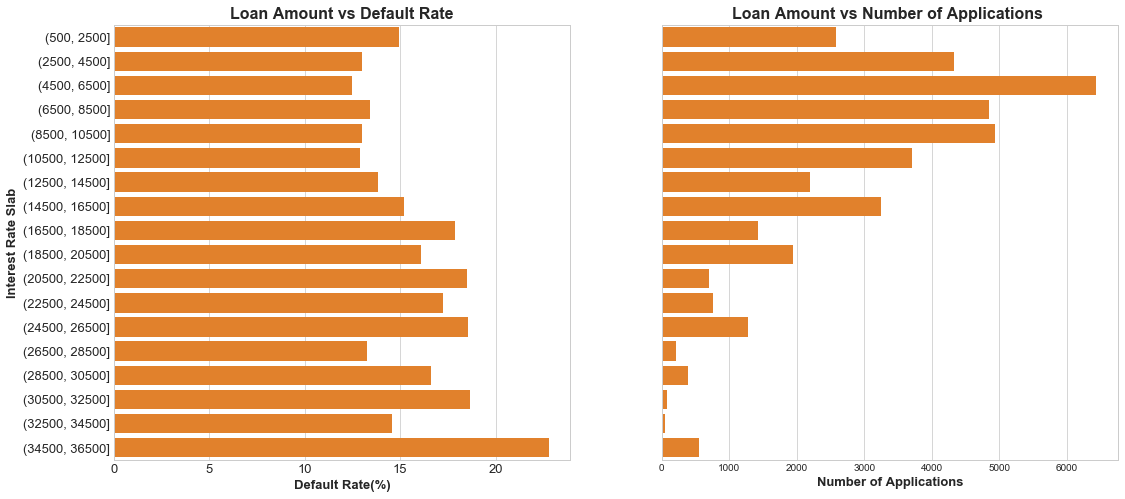

In [38]:
plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
sns.barplot(data=grp[grp.loan_status == "Charged Off"], 
            y="loan_amt_slab", x="rod", color = color[1])
plt.title("Loan Amount vs Default Rate", fontsize = 16, fontweight='bold')
plt.xlabel("Default Rate(%)", fontsize = 13, fontweight = 'bold')
plt.ylabel("Interest Rate Slab", fontsize = 13, fontweight = 'bold')
plt.xticks(fontsize =13)
plt.yticks(fontsize =13)
plt.plot()


plt.subplot(1, 2, 2)
sns.barplot(data=grp[grp.loan_status == "Charged Off"], 
            y="loan_amt_slab", x="n_appl", color = color[1])
plt.title("Loan Amount vs Number of Applications ", fontsize = 16, fontweight='bold')
plt.xlabel("Number of Applications", fontsize = 13, fontweight = 'bold')
plt.ylabel("")
plt.yticks([], [])
plt.plot()

We see that there is an eventual rise in default rate with increase of sanctioned loan amount but the incraese is not very deterministic in nature. Also, the number of application goes down with higher loan amount, so with less sample size on higher loan amount brackets - the confidence level of our claim based on EDA decreases. Nonetheless, it looks like loan amount has an effect on default rate. Let's find out if we can find some more strong drivers of charge off.

[]

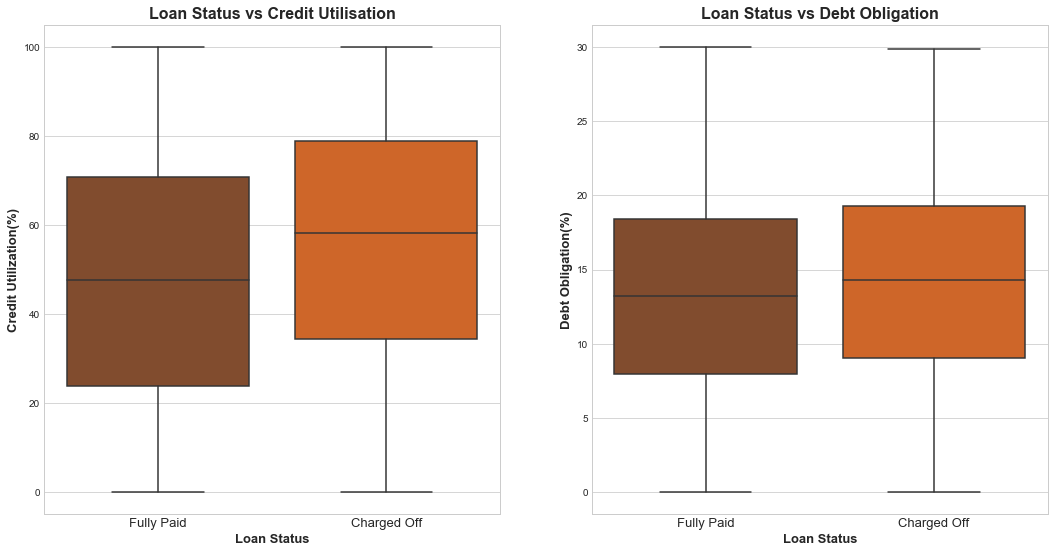

In [39]:
plt.figure(figsize=(18, 9))

plt.subplot(1, 2, 1)
sns.boxplot(data=loans[(loans.loan_status == "Charged Off") | (loans.loan_status == "Fully Paid")], 
            x="loan_status", y = "revol_util", palette=sns.color_palette("Oranges_d", 3))
plt.title("Loan Status vs Credit Utilisation", fontsize = 16, fontweight='bold')
plt.xlabel("Loan Status", fontsize = 13, fontweight = 'bold')
plt.ylabel("Credit Utilization(%)", fontsize = 13, fontweight = 'bold')
plt.xticks(fontsize =13)

plt.subplot(1, 2, 2)
sns.boxplot(data=loans[(loans.loan_status == "Charged Off") | (loans.loan_status == "Fully Paid")], 
            x="loan_status", y = "dti", palette=sns.color_palette("Oranges_d", 3))
plt.title("Loan Status vs Debt Obligation", fontsize = 16, fontweight='bold')
plt.xlabel("Loan Status", fontsize = 13, fontweight = 'bold')
plt.ylabel("Debt Obligation(%)", fontsize = 13, fontweight = 'bold')
plt.xticks(fontsize =13)


plt.plot()

On the left hand side in the above graph we plotted the distribution of credit utlizations for people who have successfully paid the loan over time and for people who have defaulted. Credit utilisation is a very important financial metric which indicates how a particular individiual has utilised her credit line in the past. For someone who has been consistently exploiting her credit lines to a level close to her total credit limit - it is likely that she would run into some major financial problem in future when she won't be able to meet her debt obligations. The graph also conveys the same message as we can see **for people who have paid-off their loans the credit utilisation history yields a lower average value than that for those who have defaulted**.

On the right hand side we plot the the ratio of total debt payable (including the EMI for the loan taken from the LC) to income. This makes sense due to the fact that our debt payment capability is directly proportional to our income. Hence, it's no surprise to see that **people with higher debt payable ratio tend to default more often**. A very simple explanation for this is that people with low income and high debt obligation might not have the surplus money to pay the installments after paying for their monthly recurring expenses.

Talking about income, let's explore how income verification might prove crucial for the LC. We divide the whole population to two groups - for whom the income was verified (or source verified) by the LC and for whom the income was not verified.

In [40]:
print("{}% applicants have unverified income in the dataset.".format("%.2f" %
    (loans.verification_status.value_counts(normalize=True)["Not Verified"]*100)))

42.60% applicants have unverified income in the dataset.


In [41]:
loans["is_income_verified"] = "Yes"
loans["is_income_verified"][loans["verification_status"] == "Not Verified"] = "No"

incver_rod = loans.groupby(["loan_status", "is_income_verified"])["member_id"].agg("size").reset_index()
incver_rod["n_appl"] = incver_rod.groupby("is_income_verified")["member_id"].transform("sum")
incver_rod["rod_pct"] = 100 * (incver_rod["member_id"] / incver_rod["n_appl"])

[]

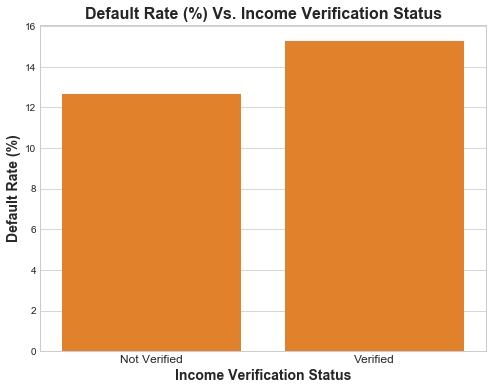

In [42]:
plt.figure(figsize=(8, 6))
sns.barplot(data=incver_rod[incver_rod["loan_status"] == "Charged Off"], 
            x = "is_income_verified",
           y = "rod_pct", color = color[1])
plt.title("Default Rate (%) Vs. Income Verification Status", fontsize = 16, fontweight='bold')
plt.xlabel("Income Verification Status", fontsize = 14, fontweight = 'bold')
plt.ylabel("Default Rate (%)", fontsize = 14, fontweight = 'bold')
plt.xticks([0, 1],["Not Verified", "Verified"], fontsize= 12)
plt.plot()

This is quite counter intuitive. What we see is that for people for whom the income has not been verified the default rate is lower by more than 2%. Its also not clear why the LC didn't verify the income for a substantial proportion of applicants.

What about loan purpose i.e. the reason that the applicant cited while taking the loan? Is there any specific purpose which is more vulnerable than others? Let's find out.

[]

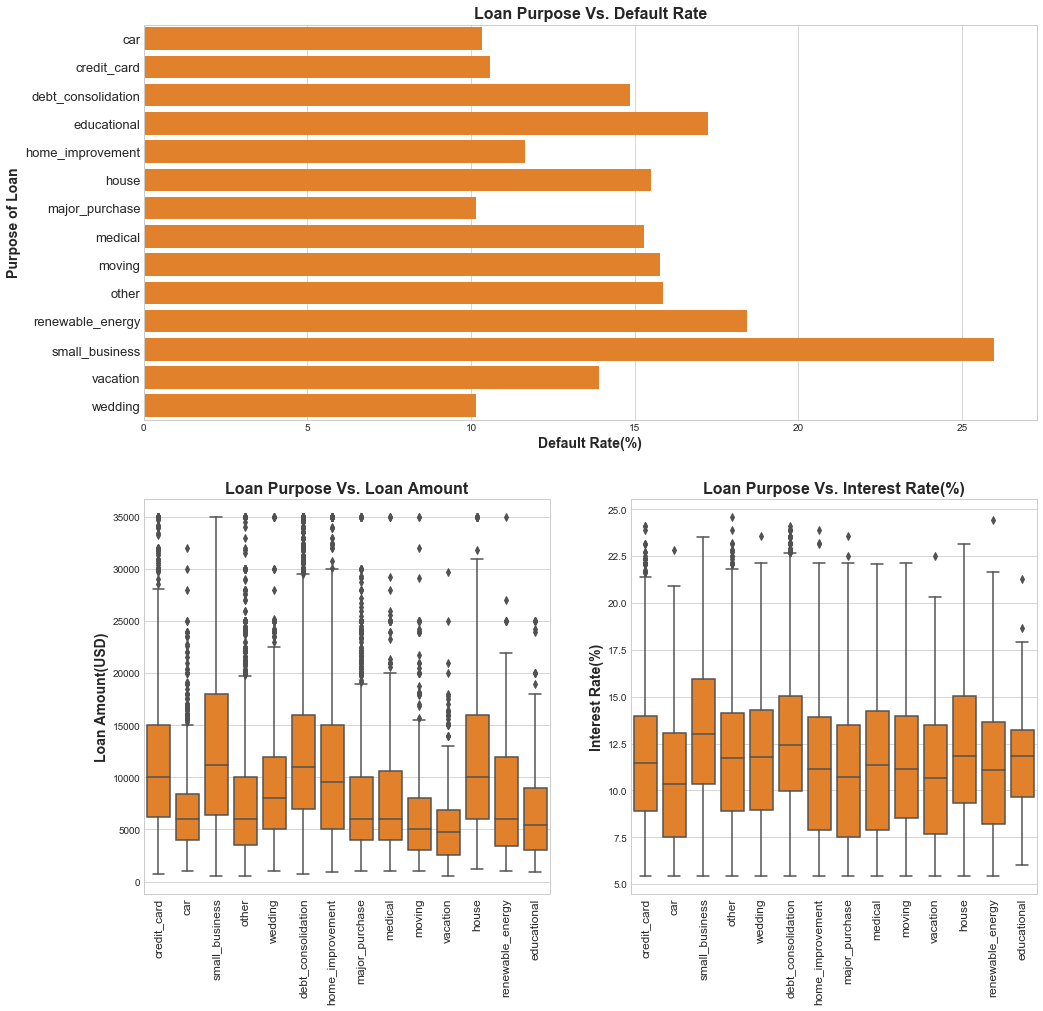

In [117]:
purpose_rod = loans.groupby(["purpose", "loan_status"])["id"].count().reset_index()
purpose_rod["n_appl"] = purpose_rod.groupby("purpose")["id"].transform("sum")
purpose_rod["rod"] = 100 * (purpose_rod["id"] / purpose_rod["n_appl"])

plt.figure(figsize=(16, 16))

plt.subplot(2, 1, 1)
sns.barplot(data=purpose_rod[purpose_rod.loan_status =='Charged Off'], 
                             x="rod", y = 'purpose', color = color[1])
plt.title("Loan Purpose Vs. Default Rate", fontsize = 16, fontweight = 'bold')
plt.xlabel("Default Rate(%)", fontsize = 14, fontweight = 'bold')
plt.ylabel("Purpose of Loan", fontsize = 14, fontweight = 'bold')
plt.yticks(fontsize = 13)

plt.subplot(2, 2, 3)
sns.boxplot(data=loans, x="purpose", y = "funded_amnt", color = color[1])
plt.title("Loan Purpose Vs. Loan Amount", fontsize = 16, fontweight = 'bold')
plt.ylabel("Loan Amount(USD)", fontsize = 14, fontweight = 'bold')
plt.xlabel("")
plt.xticks(rotation = 'vertical', fontsize = 12)

plt.subplot(2, 2, 4)
sns.boxplot(data=loans, x="purpose", y = "int_rate", color = color[1])
plt.title("Loan Purpose Vs. Interest Rate(%)", fontsize = 16, fontweight = 'bold')
plt.ylabel("Interest Rate(%)", fontsize = 14, fontweight = 'bold')
plt.xlabel("")
plt.xticks(rotation = 'vertical', fontsize = 12)
plt.plot()

In fact, there are categories that attract more defaults than others, the most risky segment being the applicants applying a **loan for a small business**. From the graph (top one) we can see that, that segment **has a staggering default rate which is well over 25%**. We also find out that, people applying loans for small business, often request a bulk amount which is higher than other categories in an average. On the other hand, small business loans also attract a higher interest rate compared to others. So this is one of the segment, where LendingClub has to be really proactive in filtering out the risky propositions. 

Apart from small business loans, **educational and renewable energy loans are also subject to higher default rates** than overall average. Educational loans are typically small in size ranging around USD `$`5,000 but surprisingly charges moderately high interest rates near 12.5%. Given, the cohort that apply for educational loans are often people who are yet to start their professional career or just got started with it while pursuing higher level education - the excess burden that the high interest rate imposes on them might be hard for them to cope with winding up in a default. To the end of renewable energy loans, it's not very clear what triggers the high default rate as they the loan amount and interest rate both seem to be fair in that case.

Let's also pay some attention to the variable indicating the number of credit enquiries in the last 6 months. Our hypothesis is people who have been credit hungry in the recent past, they are already down the slippery slope of debt burden and a large number of enquiries reflect their desperation to get a credit to fend off their existing debt. Let's see what the data has to convey. 

[]

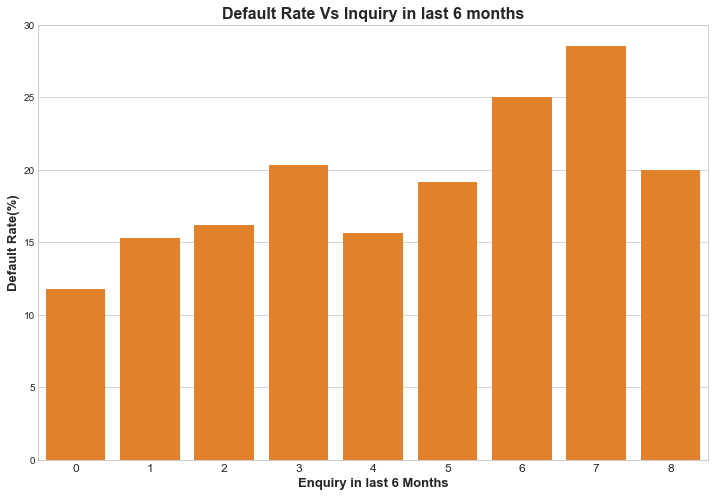

In [43]:
s = loans.groupby(["loan_status", "inq_last_6mths"])["id"].agg("size").reset_index()
s["n_appl"] = s.groupby("inq_last_6mths")["id"].transform("sum")
s["rod_pct"] = 100 * (s["id"] / s["n_appl"])

plt.figure(figsize=(12, 8))
sns.barplot(data = s[s.loan_status == 'Charged Off'], x = "inq_last_6mths", y = "rod_pct", color = color[1])
plt.title("Default Rate Vs Inquiry in last 6 months", fontsize = 16, fontweight='bold')
plt.xlabel("Enquiry in last 6 Months", fontsize = 13, fontweight = 'bold')
plt.ylabel("Default Rate(%)", fontsize = 13, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.plot()

Looks like a pattern there. While applicants with no credit enquiries in the last 6 months got only about ~12% of defaults, as we go up in the chart we see **people with more than 4 enquiries have consistently around ~20% of default rate** which is substantially higher than the overall default rate (14%) in the data. 

Let's now look at the length of employment of the applicants and if it has any effect on the charged off rate.

[]

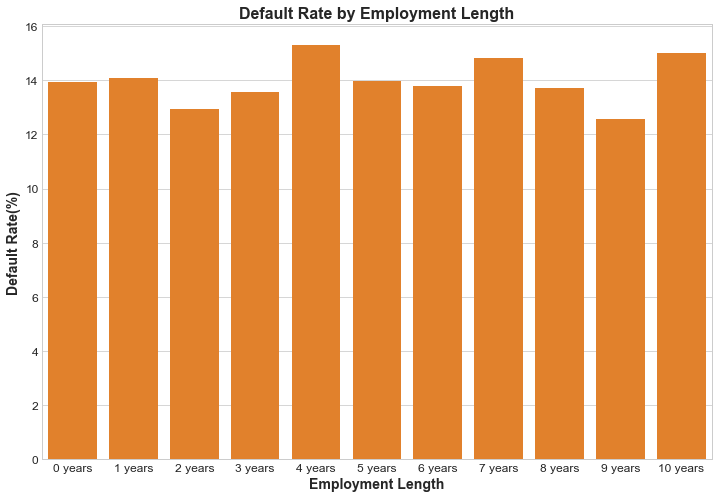

In [44]:
empl_rod = loans.groupby(["loan_status", "emp_length"])["member_id"].agg("size").reset_index()
empl_rod["n_appl"] = empl_rod.groupby("emp_length")["member_id"].transform("sum")
empl_rod["rod"] = 100 * (empl_rod["member_id"] / empl_rod["n_appl"])

plt.figure(figsize=(12, 8))
sns.barplot(data=empl_rod[empl_rod.loan_status == "Charged Off"], 
            x="emp_length", y="rod", color = color[1])
plt.title("Default Rate by Employment Length", fontsize = 16, fontweight='bold')
plt.xlabel("Employment Length", fontsize = 14, fontweight = 'bold')
plt.ylabel("Default Rate(%)", fontsize = 14, fontweight = 'bold')
plt.yticks(fontsize =12)
locs, labs = plt.xticks()
labs = [l.get_text() for l in labs]
plt.xticks(locs, [x.replace(".0", "") + ' years' for x in labs], fontsize = 12)
plt.plot()

The default rate seems to be more or less uniformly distributed over professional experience. The peaks at 4, 7 and 10 years are kind of interesting though in that they are equispaced but why that might be the case is not clear at this stage.

Let us also check if there is any trend over time for defaults. This will give us a fair idea how LendingClub is taking necessary measures to guard against defaulters.

[]

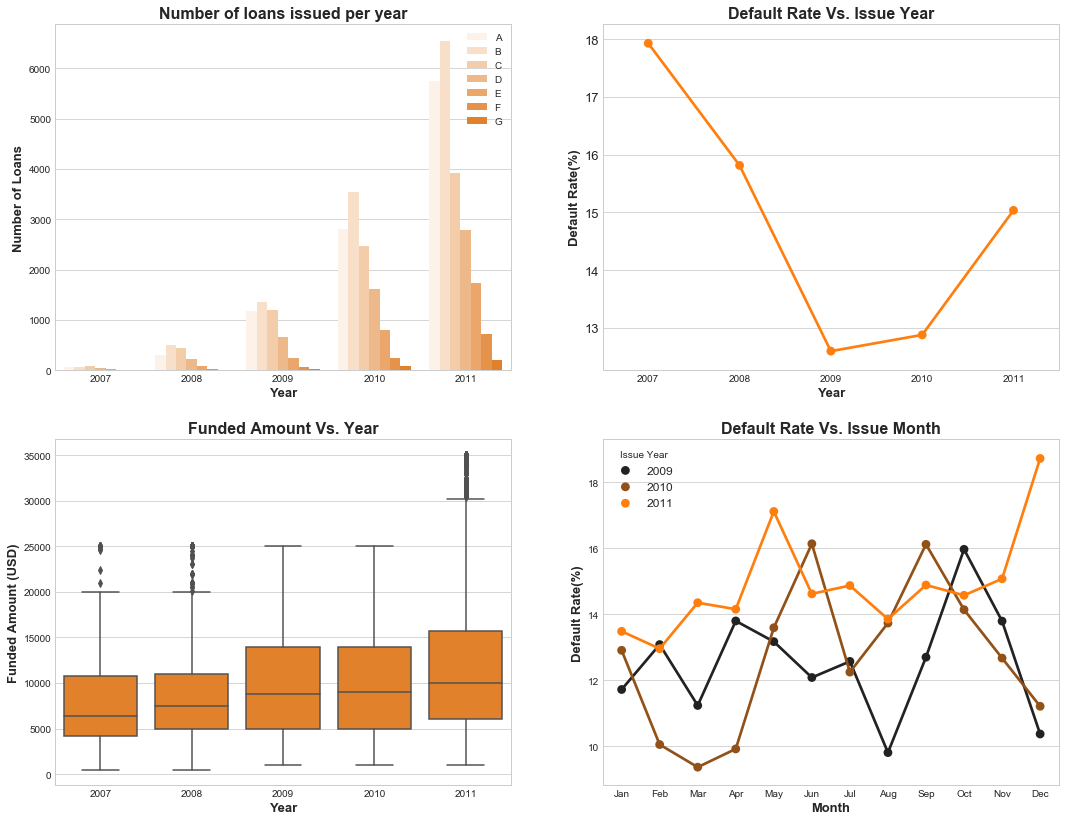

In [219]:
temp = loans.groupby(["loan_status", "issue_d_year"])["member_id"].agg("size").reset_index()
temp["n_appl"] = temp.groupby("issue_d_year")["member_id"].transform("sum")
temp["rod"] = 100 * (temp["member_id"] / temp["n_appl"])

temp2 = loans.groupby(["loan_status", "issue_d_year", "issue_d_month"])["member_id"].agg("size").reset_index()
temp2["n_appl"] = temp2.groupby(["issue_d_year", "issue_d_month"])["member_id"].transform("sum")
temp2["rod"] = 100 * (temp2["member_id"] / temp2["n_appl"])
inv_month_dict = {v: k for k, v in month_dict.items()}
temp2["issue_d_month"] = temp2.issue_d_month.map(inv_month_dict)

keys = list('ABCDEFG')
vals = [ord(x) - 64 for x in keys]
grade_dict = dict(zip(keys, vals))
loans["grade_num"] = loans["grade"].map(grade_dict )

plt.figure(figsize=(18, 14))

plt.subplot(2, 2, 1)
ax = sns.countplot(data=loans, x="issue_d_year", color = color[1], hue = "grade_num")
plt.title("Number of loans issued per year", fontsize = 16, fontweight='bold')
plt.xlabel("Year", fontsize = 13, fontweight = 'bold')
plt.ylabel("Number of Loans", fontsize = 13, fontweight = 'bold')
ax.legend(labels = keys)

plt.subplot(2, 2, 2)
sns.pointplot(data=temp[temp.loan_status == "Charged Off"], 
            x="issue_d_year", y="rod",color = color[1])
plt.title("Default Rate Vs. Issue Year", fontsize = 16, fontweight='bold')
plt.xlabel("Year", fontsize = 13, fontweight = 'bold')
plt.ylabel("Default Rate(%)", fontsize = 13, fontweight = 'bold')
plt.yticks(fontsize =13)

plt.subplot(2, 2, 3)
sns.boxplot(data=loans, y = "funded_amnt", x = "issue_d_year", color = color[1])
plt.title("Funded Amount Vs. Year", fontsize = 16, fontweight='bold')
plt.xlabel("Year", fontsize = 13, fontweight = 'bold')
plt.ylabel("Funded Amount (USD)", fontsize = 13, fontweight = 'bold')

plt.subplot(2, 2, 4)
dt = temp2[(temp2.issue_d_year == 2011) | (temp2.issue_d_year == 2010) | (temp2.issue_d_year == 2009)]
sns.pointplot(data=dt[(dt.loan_status == 'Charged Off')], x = "issue_d_month", 
              y = "rod", hue = "issue_d_year",color= color[1])
plt.title("Default Rate Vs. Issue Month", fontsize = 16, fontweight='bold')
plt.xlabel("Month", fontsize = 13, fontweight = 'bold')
plt.ylabel("Default Rate(%)", fontsize = 13, fontweight = 'bold')
plt.legend(title = "Issue Year", fontsize = 12)
plt.plot()

So, a lot is going on above. One the top left corner, we plotted how the LC has evolved over time in that how many loans were issued by the company in each grade through the years 2007 to 2011. We find that there has been a steady growth for the LC over the years and 'B' has historically been the most popular loan grade for the LC. However, the growth has been uniform in both *good*(light shades) and *bad*(dark shades) categories. As the number of issued loans increased year on year, we can see from the graph on bottom left that the corpus of the funded amount has also grown - but in this case the growth is a bit diminished. Can we relate this with the overall defaulted behavior of the applicants?

On the top right hand side we see that, subsequent to the inception of the LC in 2007 (given a very small number of loans issued in 2007 - we can presume that that is when the LC came into operation) - the LC faught off defaults pretty well until 2011 where the rate of default suddenly took off again. If we notice the boxplot (bottom left) carefully, we can observe the long upward whisker corresponding to the year 2011 which represents the **LC went out of its usual lending behavior in 2011 and issued a number of loans with very high amounts**. In fact a total of 1,411 loans with an amount of USD `$`25,000 were issued in that year among which 272 resulted in default - that alone has a default rate of close to ~20`%`. **Approving loans with amount much higher than usual costed the LC potential credit loss.**

If we take another look at the bottom right graph we see that in last 3 years, **Dec-2011 has the highest default rate well over 19%**. Given the fact that the **average loan amount of all 2260 loans issued in Dec-2011 is more than USD `$`13,000** (the historical average is ~`$`11,000) - the rate of default at that period comes with no surprise.

## 4) Bivariate Analysis

In this section, let us explore more about correlation between different variables and how that might play a role in driving the default rate. To start with, let us plot the correlation matrix of the numeric variables.

[]

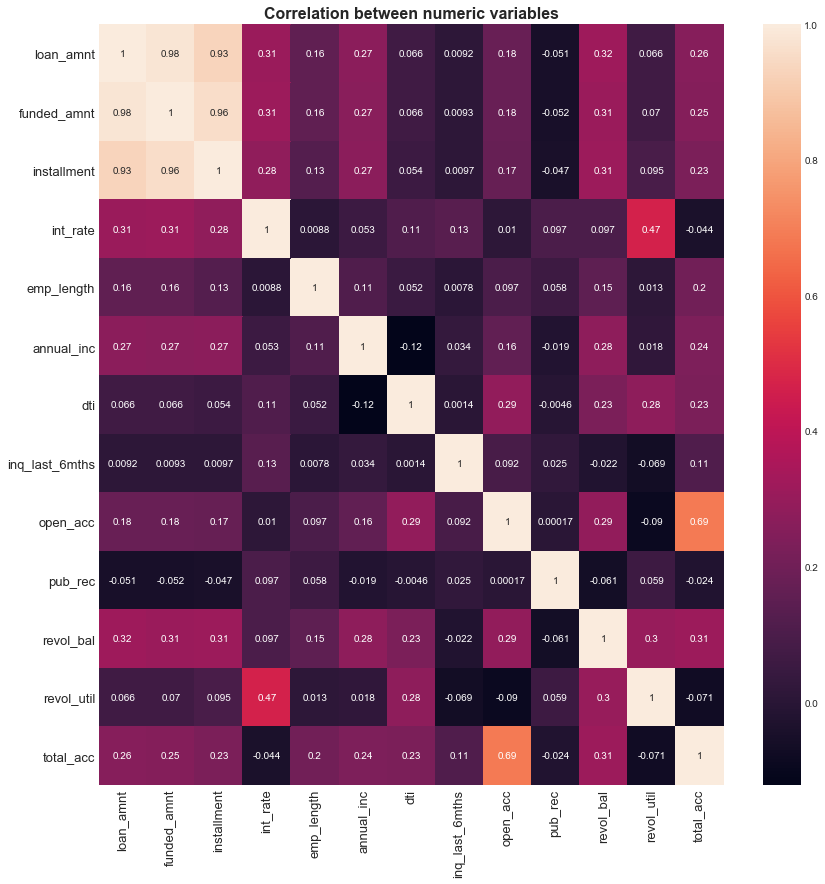

In [123]:
num_vars = ["loan_amnt", "funded_amnt", "term", "installment", "int_rate", "emp_length", "annual_inc", "dti", 
            "inq_last_6mths", "open_acc", "pub_rec", "revol_bal", "revol_util", "total_acc"]
plt.figure(figsize=(14, 14))
corr = loans[num_vars].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,annot=True)
plt.title("Correlation between numeric variables", fontsize = 16, fontweight = 'bold')
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.plot()

Nothing out of the box. Loan amount, funded amount and installment to have a very high correlation as we had expected. However, one can guess to have a high correlation between annual income and loan amount, but in the data although the correlation is positive, the magnitude of that is pretty low indicating annual income is not a strong driver of the sancationed loan amount. We also notice, **the rate of credit utilization has a positive correlation with interest rate** - which makes sense as higher credit utilization reflects on lower financial stability and hence attracts a higher interest rate. There is also a slight negtive correlation between annual income and debt payable which is intuitive from the fact that debt payable is a ratio where the annual income is taken as the denominator.

So, continuous variables did not convey much about defaulters. Let's look at a few joint distributions of categorical variables.

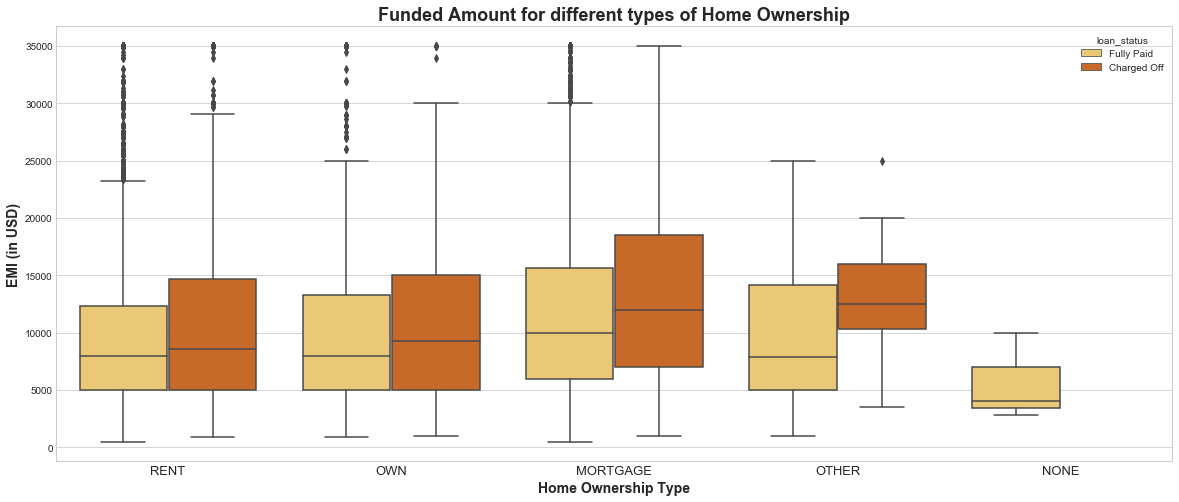

In [230]:
plt.figure(figsize=(20,8))
sns.boxplot(data =loans[(loans.loan_status == 'Fully Paid') | (loans.loan_status == 'Charged Off')], 
            x='home_ownership', y='funded_amnt', hue ='loan_status', palette=sns.color_palette("YlOrBr", 2))
plt.title('Funded Amount for different types of Home Ownership', fontsize = 18, fontweight = 'bold')
plt.xlabel('Home Ownership Type',fontsize = 14, fontweight = 'bold' )
plt.ylabel('EMI (in USD)', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 13)
plt.show()

As we see, funded amount in almost all type of home ownerships are similar apart from the category *Others.* The charged off loans in the other category has got a distinctive difference with the paid-off loans in terms of funding amount. With this in mind, LendingClub should be very precautious while approving high amounts for 'Other' type of home ownership applicants.

<Figure size 1440x576 with 0 Axes>

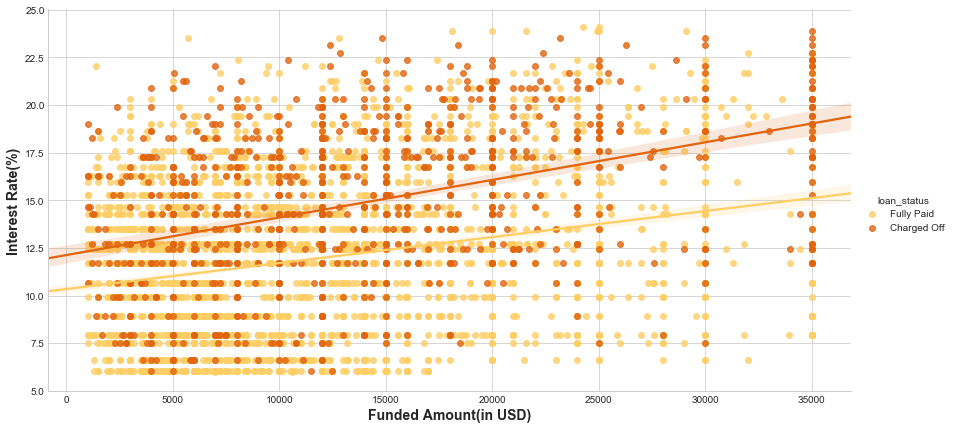

In [228]:
plt.figure(figsize=(20,8))
sns.lmplot(data =loans[(loans.loan_status == 'Fully Paid') | (loans.loan_status == 'Charged Off')].iloc[:5000],
            x='funded_amnt', y='int_rate', hue = 'loan_status',
          size=6, aspect=2, scatter_kws={'s':35}, palette=sns.color_palette("YlOrBr", 2))
plt.xlabel("Funded Amount(in USD)", fontsize = 14, fontweight = 'bold')
plt.ylabel("Interest Rate(%)", fontsize = 14, fontweight = 'bold')

plt.show()

From the graph above, we can clearly see that for a fixed loan amount, how the interest rates are different between the fully paid and charged off cases - being much higher for the latter. The difference also increases along with the loan amount.

Let's take a look at the default rate for different loan purpose and employment experience.

[]

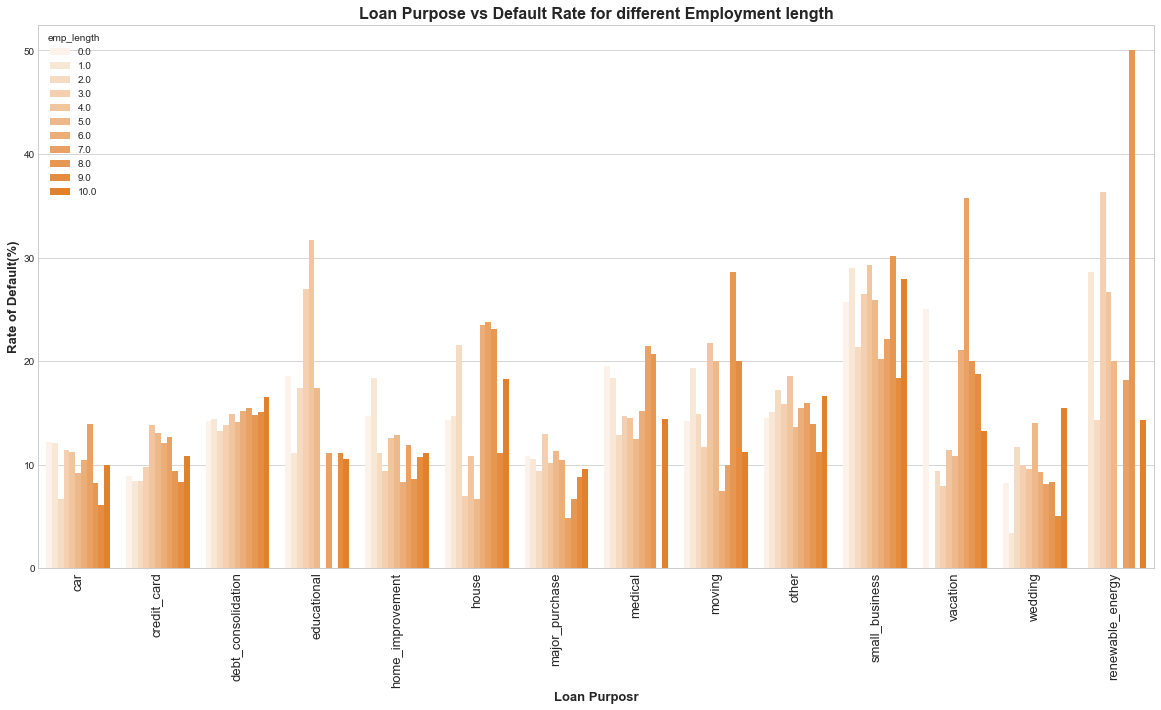

In [278]:
temp  = loans.groupby(["emp_length", "purpose", "loan_status"])["id"].count().reset_index()
temp["n_appl"] = temp.groupby(["emp_length", "purpose"])["id"].transform("sum")
temp["rod"] = 100 * (temp["id"] / temp["n_appl"])

plt.figure(figsize=(20, 10))
sns.barplot(data=temp[temp.loan_status == "Charged Off"], x="purpose", y = "rod", hue="emp_length", color = color[1])
plt.title("Loan Purpose vs Default Rate for different Employment length", fontsize = 16, fontweight='bold')
plt.xlabel("Loan Purposr", fontsize = 13, fontweight = 'bold')
plt.ylabel("Rate of Default(%)", fontsize = 13, fontweight = 'bold')
plt.xticks(fontsize = 13, rotation = 90)
plt.plot()

We see a number of different patterns for different purposes above. To start with loans issued for car, credit card, wedding, major purchase and debt consolidation are more or less secure across different employment experience levels. On the other hand we see big spikes representing higher default rates for small business, vacation, house, renewable energy and educational loans. Small business is where the rate of default is high for almost all the experience levels whereas for education loan the experience in range of 4-5 years are very risky. 
However, there does not seem to be a direct correlation of default rate with experience level for any of the above listed purposes.

<Figure size 1440x576 with 0 Axes>

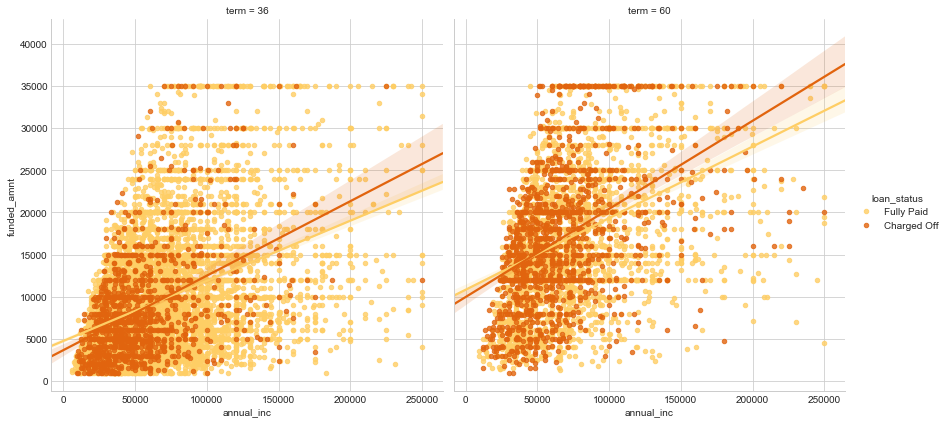

In [250]:
plt.figure(figsize=(20,8))
dt = loans[loans.annual_inc <= 250000]
sns.lmplot(data =dt[(dt.loan_status == 'Fully Paid') | (dt.loan_status == 'Charged Off')].iloc[:15000],
            x='annual_inc', y='funded_amnt', hue = 'loan_status', col = 'term',
          size=6, aspect=1, scatter_kws={'s':20}, palette=sns.color_palette("YlOrBr", 2))
#plt.xlabel("Funded Amount(in USD)", fontsize = 14, fontweight = 'bold')
#plt.ylabel("Interest Rate(%)", fontsize = 14, fontweight = 'bold')

plt.show()

The distribution of loan amount with respect to annual income looks a bit different for different repayment tenures in that how the cluster of paid-off and charged-off are located. For a 3 year's term, we see the bad loans are more better described by low-income and low-amount region whereas for the longer term (i.e. 5 year's term) the bad loans share over the region low-income and high amount.

We also derived a few variables in the early stage of our analysis which we thought would provide useful insights going ahead. Let's look at a few of those variables. 

Most interesting is the difference between requested loan amount and funded amount. When LendingClub cuts on the requested loan amount they probably assess the fact that the borrower might not be able to repay the amount asked for and hence reduces the amount. This, in fact, is also an indication of the financial health of the applicant. **The difference between the requested and approved loan amount reflects on how much disproportionate is the borrower's financial health and financial need.**

[]

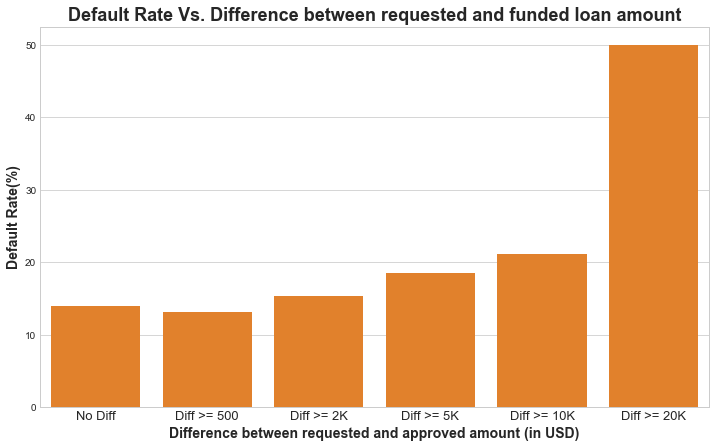

In [268]:
loans["diff_bin"] = "No Diff"
loans["diff_bin"][loans["diff_loanAmt_fundAmt"] >= 500] = "Diff >= 500"
loans["diff_bin"][loans["diff_loanAmt_fundAmt"] >= 2000] = "Diff >= 2K"
loans["diff_bin"][loans["diff_loanAmt_fundAmt"] >= 5000] = "Diff >= 5K"
loans["diff_bin"][loans["diff_loanAmt_fundAmt"] >= 10000] = "Diff >= 10K"
loans["diff_bin"][loans["diff_loanAmt_fundAmt"] >= 20000] = "Diff >= 20K"

temp = loans.groupby(["loan_status", "diff_bin"])["member_id"].agg("size").reset_index()
temp["n_appl"] = temp.groupby("diff_bin")["member_id"].transform("sum")
temp["rod"] = 100 * (temp["member_id"] / temp["n_appl"])

plt.figure(figsize=(12, 7))
sns.barplot(data=temp[temp.loan_status == "Charged Off"], 
            x="diff_bin", y="rod",color = color[1],
           order=["No Diff","Diff >= 500", "Diff >= 2K", "Diff >= 5K", "Diff >= 10K", "Diff >= 20K"])

plt.title("Default Rate Vs. Difference between requested and funded loan amount", fontsize = 18, fontweight = 'bold')
plt.xlabel("Difference between requested and approved amount (in USD)", fontsize = 14, fontweight = 'bold')
plt.ylabel("Default Rate(%)", fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 13)
plt.plot()

This is just what we had expected. As the difference between the requested and funded amount increases, the default rate keeps growing steadily as well and ultimately when that difference crosses USD `$`20K, the default rate skyrockets to 50%.